# High-dimensional Regression

```{contents}
:local:
:depth: 2
```

## Learning objectives
- Explain the “curse of dimensionality” and why high-dimensional feature spaces complicate model fitting and generalization.
- Visualize multivariate feature relationships and identify collinearity using plots and summary statistics.
- Standardize and transform features and targets appropriately; justify when scaling is required.
- Construct and evaluate multiple linear regression models in high-dimensional settings with proper validation.
- Apply dimensionality reduction (e.g., PCA) and interpret explained variance and loadings; perform principal component regression and compare to baseline models.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('../settings/plot_style.mplstyle')

## High-dimensional Data

So far we have only worked with datasets that have a single input dimension. We have generated "features" from this dimension, but we have not considered the case of a problem where multiple inputs are given. This is a very common scenario, and one of the main advantages of many machine-learning methods is that they work well for "high-dimesional" data, or data with many features.

In this lecture we will work with a dataset of chemical process data provided by Dow Chemical. The data comes from a generic chemical process with the following setup:

```{figure} images/dow_process.png
:width: 800px
:align: center

Chemical process diagram for the distillation process used in the Dow process dataset.
```
Since this is a proprietary process, we do not have any details of the chemical process, but this is real data that was measured from an actual operating process.


The dataset contains a number of operating conditions for each of the units in the process, as well as the concentration of impurities in the output stream. Let's take a look:

In [2]:
import pandas as pd
import numpy as np

df = pd.read_excel('data/impurity_dataset-training.xlsx')
df.head(10) #<- shows the first 10 entries

,Date,x1:Primary Column Reflux Flow,x2:Primary Column Tails Flow,x3:Input to Primary Column Bed 3 Flow,x4:Input to Primary Column Bed 2 Flow,x5:Primary Column Feed Flow from Feed Column,x6:Primary Column Make Flow,x7:Primary Column Base Level,x8:Primary Column Reflux Drum Pressure,x9:Primary Column Condenser Reflux Drum Level,...,x36: Feed Column Recycle Flow,x37: Feed Column Tails Flow to Primary Column,x38: Feed Column Calculated DP,x39: Feed Column Steam Flow,x40: Feed Column Tails Flow,Avg_Reactor_Outlet_Impurity,Avg_Delta_Composition Primary Column,y:Impurity,Primary Column Reflux/Feed Ratio,Primary Column Make/Reflux Ratio
0,2015-12-01 00:00:00,327.813,45.7920,2095.06,2156.01,98.5005,95.4674,54.3476,41.0121,52.2353,...,62.8707,45.0085,66.6604,8.68813,99.9614,5.38024,1.49709,1.77833,3.32803,0.291226
1,2015-12-01 01:00:00,322.970,46.1643,2101.00,2182.90,98.0014,94.9673,54.2247,41.0076,52.5378,...,62.8651,45.0085,66.5496,8.70683,99.8637,5.33345,1.51392,1.76964,3.29556,0.294044
2,2015-12-01 02:00:00,319.674,45.9927,2102.96,2151.39,98.8229,96.0785,54.6130,41.0451,52.0159,...,62.8656,45.0085,66.0599,8.69269,100.2490,5.37677,1.50634,1.76095,3.23481,0.300552
3,2015-12-01 03:00:00,327.223,46.0960,2101.37,2172.14,98.7733,96.1223,54.9153,41.0405,52.9477,...,62.8669,45.0085,67.9697,8.70482,100.3200,5.32315,1.47935,1.75226,3.31287,0.293752
4,2015-12-01 04:00:00,331.177,45.8493,2114.06,2157.77,99.3231,94.7521,54.0925,40.9934,53.0507,...,62.8673,45.0085,67.6454,8.70077,100.6590,5.28227,1.44489,1.74357,3.33435,0.286107
5,2015-12-01 05:00:00,328.884,46.0729,2100.26,2134.76,99.3376,95.4188,53.9989,41.0217,53.0389,...,62.8690,45.0085,67.6828,8.69795,100.8260,5.28510,1.51144,1.73488,3.31077,0.290129
6,2015-12-01 06:00:00,327.335,46.0581,2101.57,2191.37,98.9044,94.9811,54.0685,41.0499,52.8279,...,62.8720,45.0085,66.0828,8.70780,100.3580,5.35512,1.51096,1.72619,3.30961,0.290165
7,2015-12-01 07:00:00,329.935,45.9708,2099.27,2133.95,99.6756,94.8352,54.0001,40.9886,52.7697,...,62.8694,45.0085,67.5438,8.69391,101.1360,5.31343,1.51180,1.71750,3.31009,0.287436
8,2015-12-01 08:00:00,329.128,45.8875,2099.12,2055.11,98.8823,95.0573,53.9876,41.0169,52.8802,...,62.8690,45.0085,66.9394,8.70810,100.3630,5.35183,1.48168,1.70881,3.32848,0.288816
9,2015-12-01 09:00:00,327.686,45.8192,2109.75,2185.82,98.8448,95.5414,54.0806,41.0029,53.0875,...,62.8690,45.0085,65.5845,8.69685,100.2790,5.31385,1.51268,1.70012,3.31516,0.291564


In order to work with this data we need to "clean" it to remove missing values. We will come back to this in the "data management" module. For now, just run the cell below and it will create a matrix `X` of inputs and `y` of impurity concentrations:

In [3]:
def is_real_and_finite(x):
    # used to determine if an entry is a real, finite number.
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

all_data = df[df.columns[1:]].values #drop the first column (date)
numeric_map = df[df.columns[1:]].map(is_real_and_finite)
real_rows = numeric_map.all(axis=1).copy().values #True if all values in a row are real numbers
X = np.array(all_data[real_rows,:-5], dtype='float') #drop the last 5 cols that are not inputs
y = np.array(all_data[real_rows,-3], dtype='float')
y = y.reshape(-1,1)
print(X.shape, y.shape)

(10297, 40) (10297, 1)


This is the dataset we will work with. We have 10297 data points, with 40 input variables (features) and one output variable. We can pull the names of the features (and output) in case we forget later:

In [4]:
x_names = [str(x) for x in df.columns[1:41]]
y_name = str(df.columns[-3])
print(y_name)
x_names

y:Impurity


['x1:Primary Column Reflux Flow',
 'x2:Primary Column Tails Flow',
 'x3:Input to Primary Column Bed 3 Flow',
 'x4:Input to Primary Column Bed 2 Flow',
 'x5:Primary Column Feed Flow from Feed Column',
 'x6:Primary Column Make Flow',
 'x7:Primary Column Base Level',
 'x8:Primary Column Reflux Drum Pressure',
 'x9:Primary Column Condenser Reflux Drum Level',
 'x10:Primary Column Bed1 DP',
 'x11:Primary Column Bed2 DP',
 'x12:Primary Column Bed3 DP',
 'x13:Primary Column Bed4 DP',
 'x14:Primary Column Base Pressure',
 'x15:Primary Column Head Pressure',
 'x16:Primary Column Tails Temperature',
 'x17:Primary Column Tails Temperature 1',
 'x18:Primary Column Bed 4 Temperature',
 'x19:Primary Column Bed 3 Temperature',
 'x20:Primary Column Bed 2 Temperature',
 'x21:Primary Column Bed 1 Temperature',
 'x22: Secondary Column Base Concentration',
 'x23: Flow from Input to Secondary Column',
 'x24: Secondary Column Tails Flow',
 'x25: Secondary Column Tray DP',
 'x26: Secondary Column Head Pressu

Don't worry if all this code doesn't make sense, we will revisit `pandas` in more detail later. All you need to know for now is that it cleans the data and reads it from the Excel spreadsheet into a `numpy` array. 

In this section, the goal is to predict the output, impurity, as a function of all the input variables. Notably, in reality this data comes from a time series, which means that there are internal correlations as we will discuss more in the "time series" topic. However, for now we will (incorrectly) assume that the data are "independent", meaning that we can shuffle the data points and treat them as random samples.

```{admonition} Exercise:
:class: tip

Write a function that takes three arguments: a desired feature name (a string), a list of feature names (e.g. `x_names`), and a data matrix (e.g. `X`). The function should select the desired feature name from the data matrix and return it as a 1-dimensional `numpy` array.

```


## Visualization of features

Unlike working with a single variable where we can plot "x vs. y," it is harder to build intuition for **higher-dimensional** data because we cannot directly visualize all dimensions at once. A good first step is to look at histograms of each input variable:

X dimensions: (10297, 40)
Feature names: ['x1:Primary Column Reflux Flow', 'x2:Primary Column Tails Flow', 'x3:Input to Primary Column Bed 3 Flow', 'x4:Input to Primary Column Bed 2 Flow', 'x5:Primary Column Feed Flow from Feed Column', 'x6:Primary Column Make Flow', 'x7:Primary Column Base Level', 'x8:Primary Column Reflux Drum Pressure', 'x9:Primary Column Condenser Reflux Drum Level', 'x10:Primary Column Bed1 DP', 'x11:Primary Column Bed2 DP', 'x12:Primary Column Bed3 DP', 'x13:Primary Column Bed4 DP', 'x14:Primary Column Base Pressure', 'x15:Primary Column Head Pressure', 'x16:Primary Column Tails Temperature', 'x17:Primary Column Tails Temperature 1', 'x18:Primary Column Bed 4 Temperature', 'x19:Primary Column Bed 3 Temperature', 'x20:Primary Column Bed 2 Temperature', 'x21:Primary Column Bed 1 Temperature', 'x22: Secondary Column Base Concentration', 'x23: Flow from Input to Secondary Column', 'x24: Secondary Column Tails Flow', 'x25: Secondary Column Tray DP', 'x26: Secondary Co

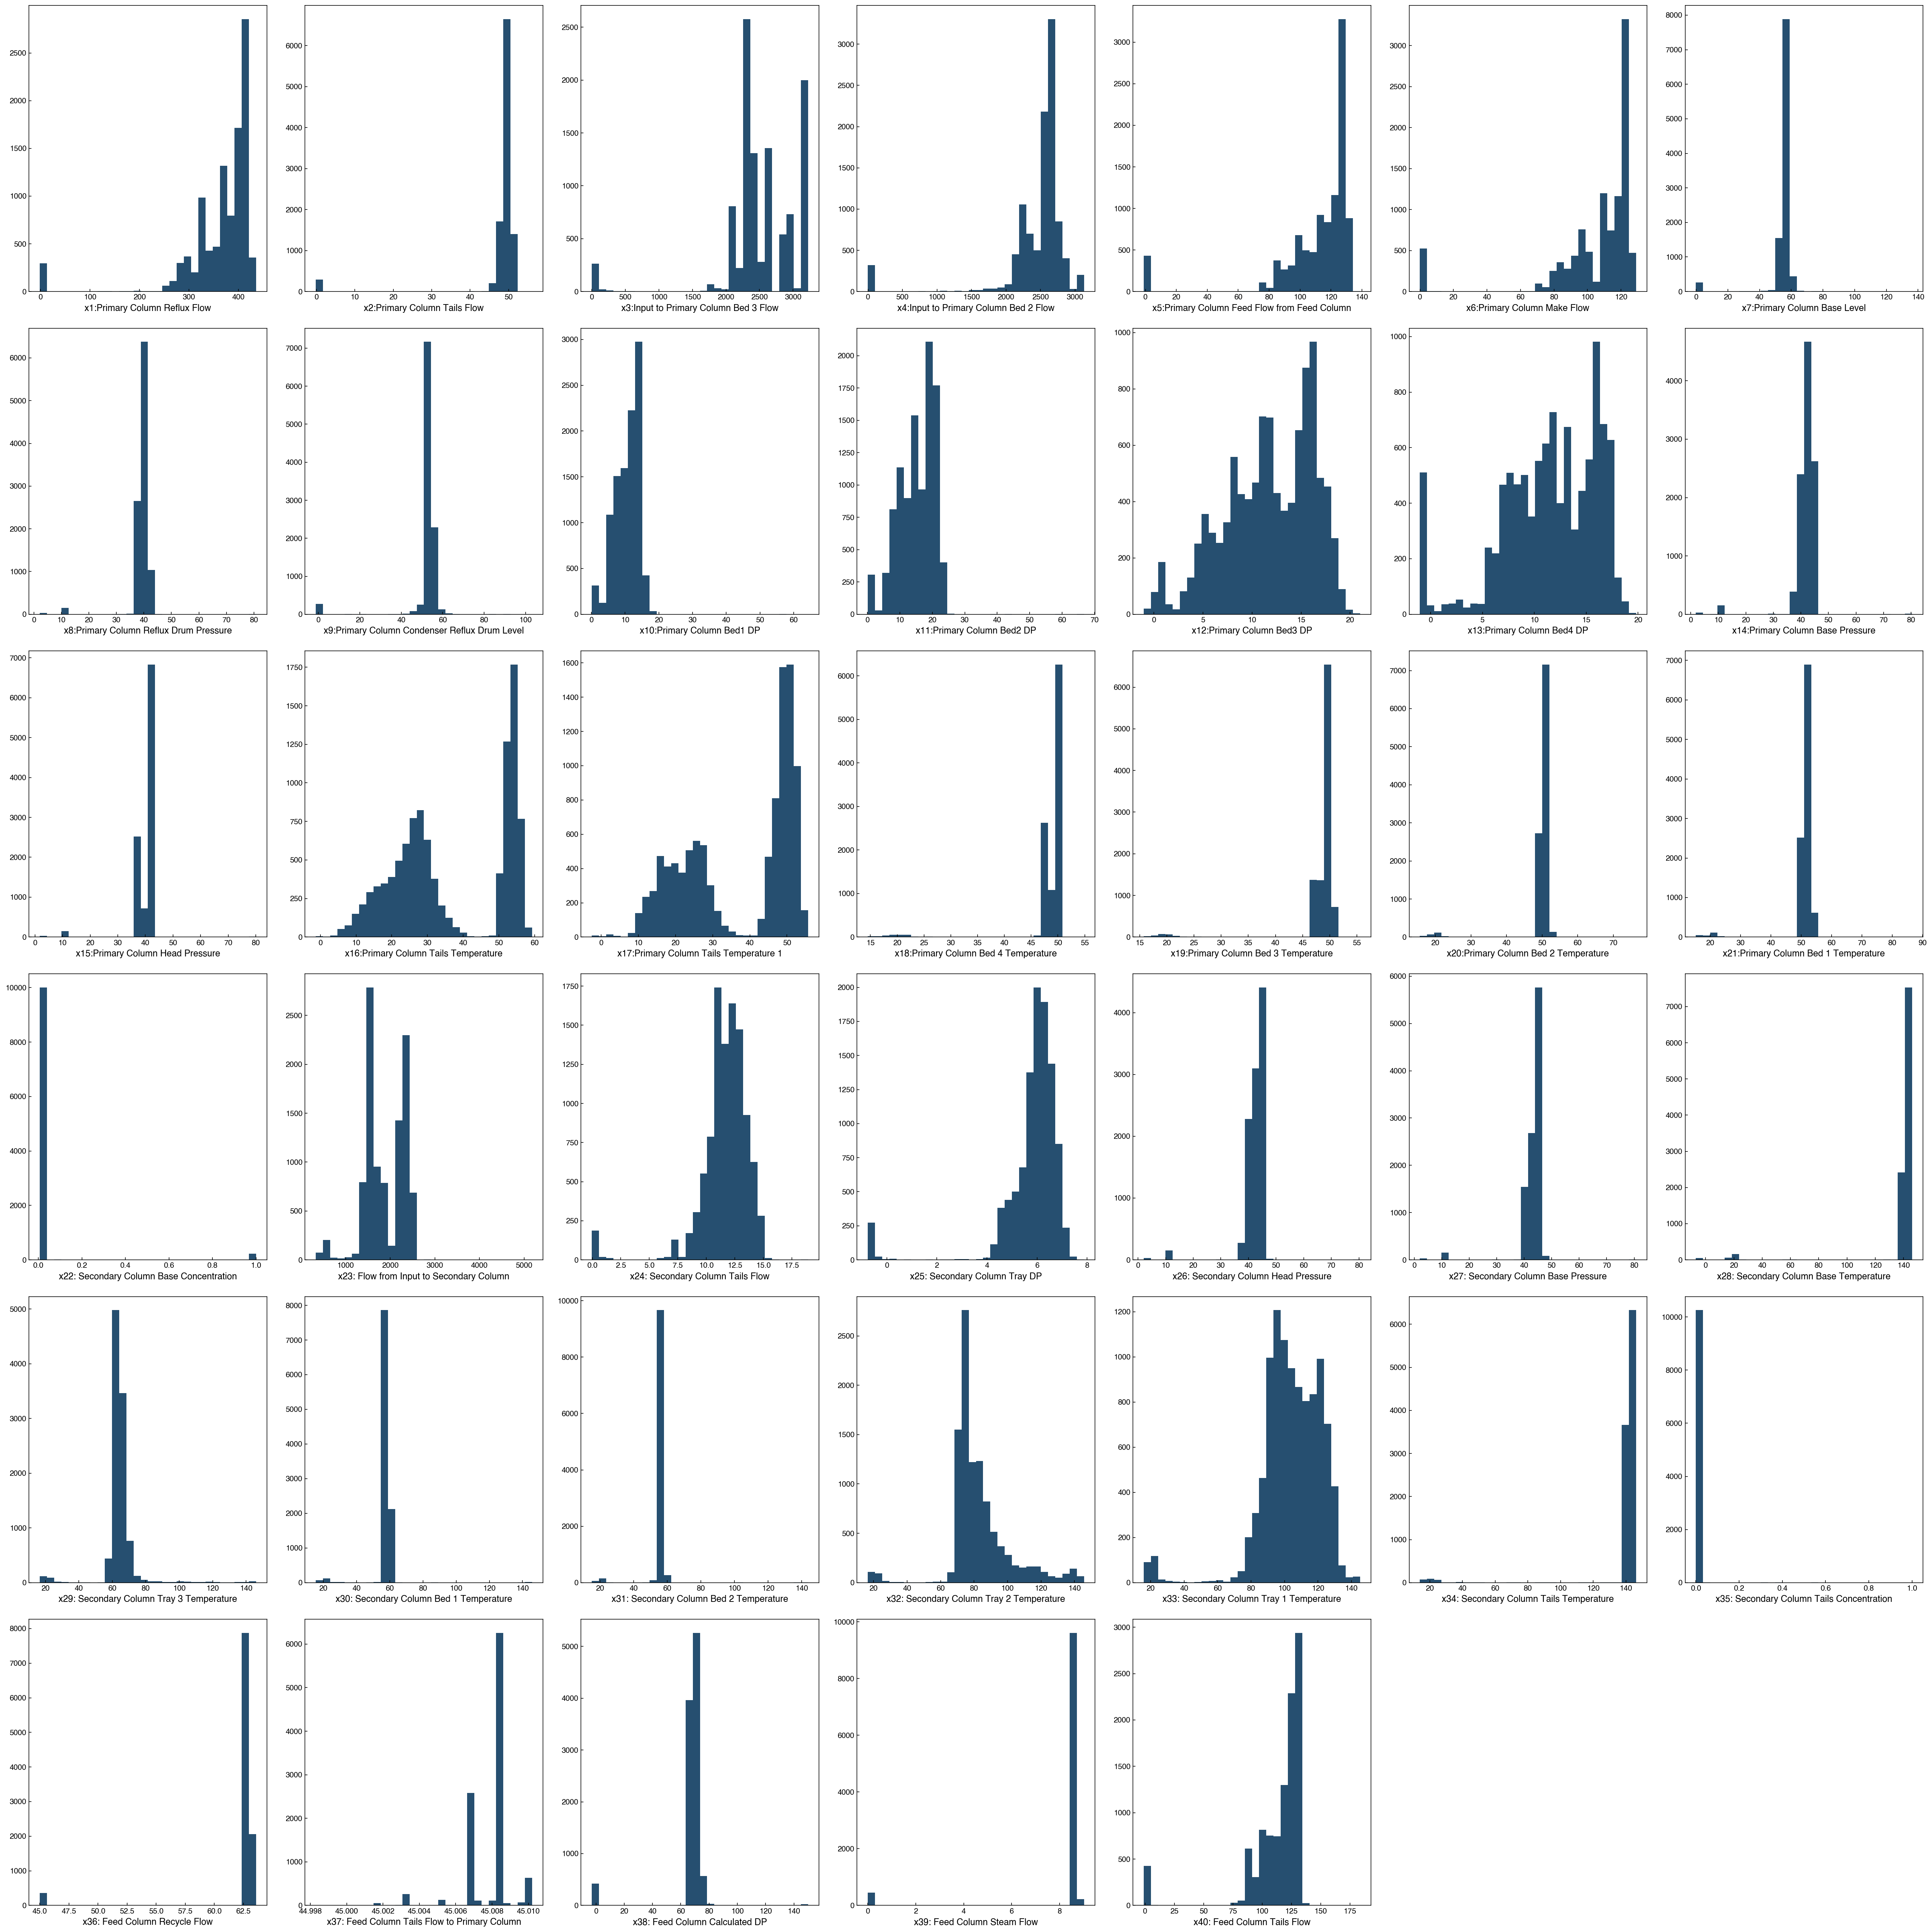

In [5]:
print(f'X dimensions: {X.shape}')
print(f'Feature names: {x_names}')

N = X.shape[-1]
n = int(np.sqrt(N))
fig, axes = plt.subplots(n, n + 1, figsize=(6*n, 6*n))
ax_list = axes.ravel()

for i in range(N):
    ax_list[i].hist(X[:, i], bins=30, alpha=0.85)
    ax_list[i].set_xlabel(x_names[i])

# Hide any unused axes (if grid has extra panels)
for j in range(N, len(ax_list)):
    ax_list[j].set_visible(False)

plt.tight_layout()

We can see that some features are approximately normally distributed, while others have obvious outliers or bimodal shapes.

```{note}
**Why might there be bimodal distributions in a chemical process?**  
Chemical processes often operate in distinct modes. For example, equipment may be "on" vs. "off," or a plant may switch among steady-state setpoints (e.g., different product grades, feedstocks, or throughput targets). Such regime changes naturally yield bimodal (or multimodal) feature distributions.
```


### Visualizing two features at a time and other first-pass strategies

A simple next step after histograms is to examine **bivariate** relationships:

- **Scatter plots** for selected feature pairs.
- **Color by the target** (`y`) to see how the response varies in the plane.
- **Small multiples** (pairwise grid) for a *subset* of features when `N` is large.

Here is an example that will plot two features:

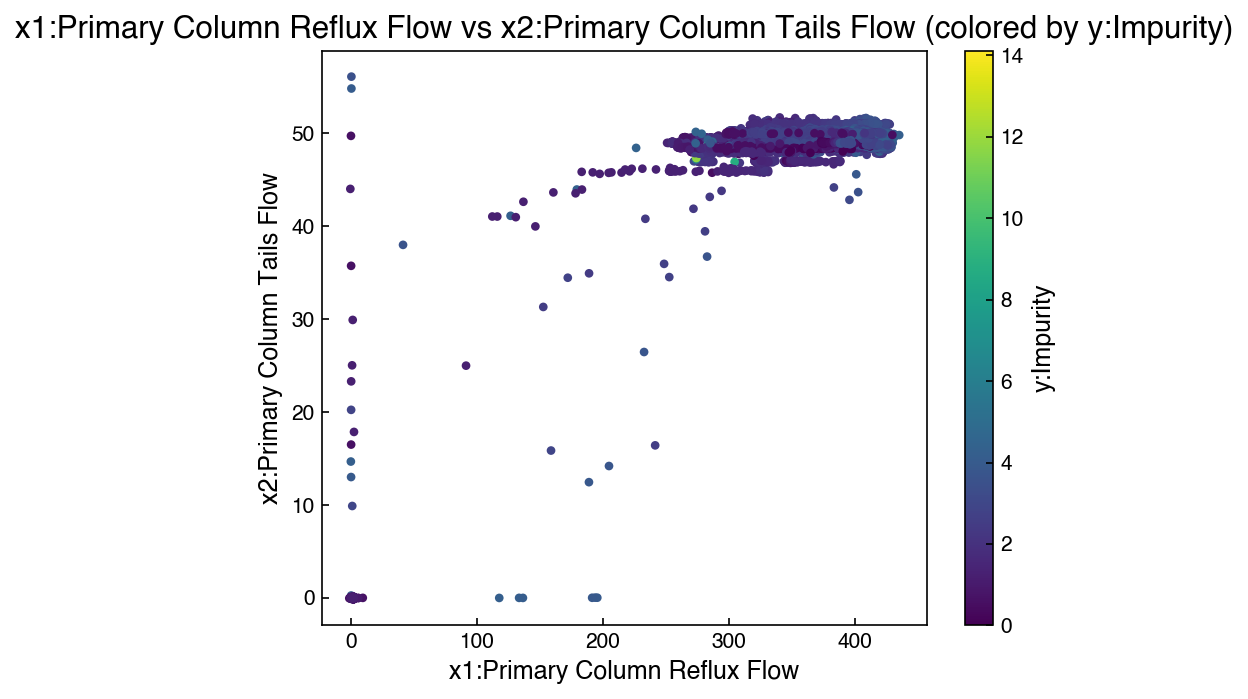

In [6]:
# Pick two features to compare
i, j = 0, 1  # change indices to explore other pairs

plt.figure(figsize=(6,5))
sc = plt.scatter(X[:, i], X[:, j], c=y.ravel(), s=10)
plt.xlabel(x_names[i]); plt.ylabel(x_names[j])
plt.title(f'{x_names[i]} vs {x_names[j]} (colored by {y_name})')
cbar = plt.colorbar(sc); cbar.set_label(y_name)
plt.tight_layout()

It is not practical to visualize an entire 40 x 40 grid, but we can select a small subset:

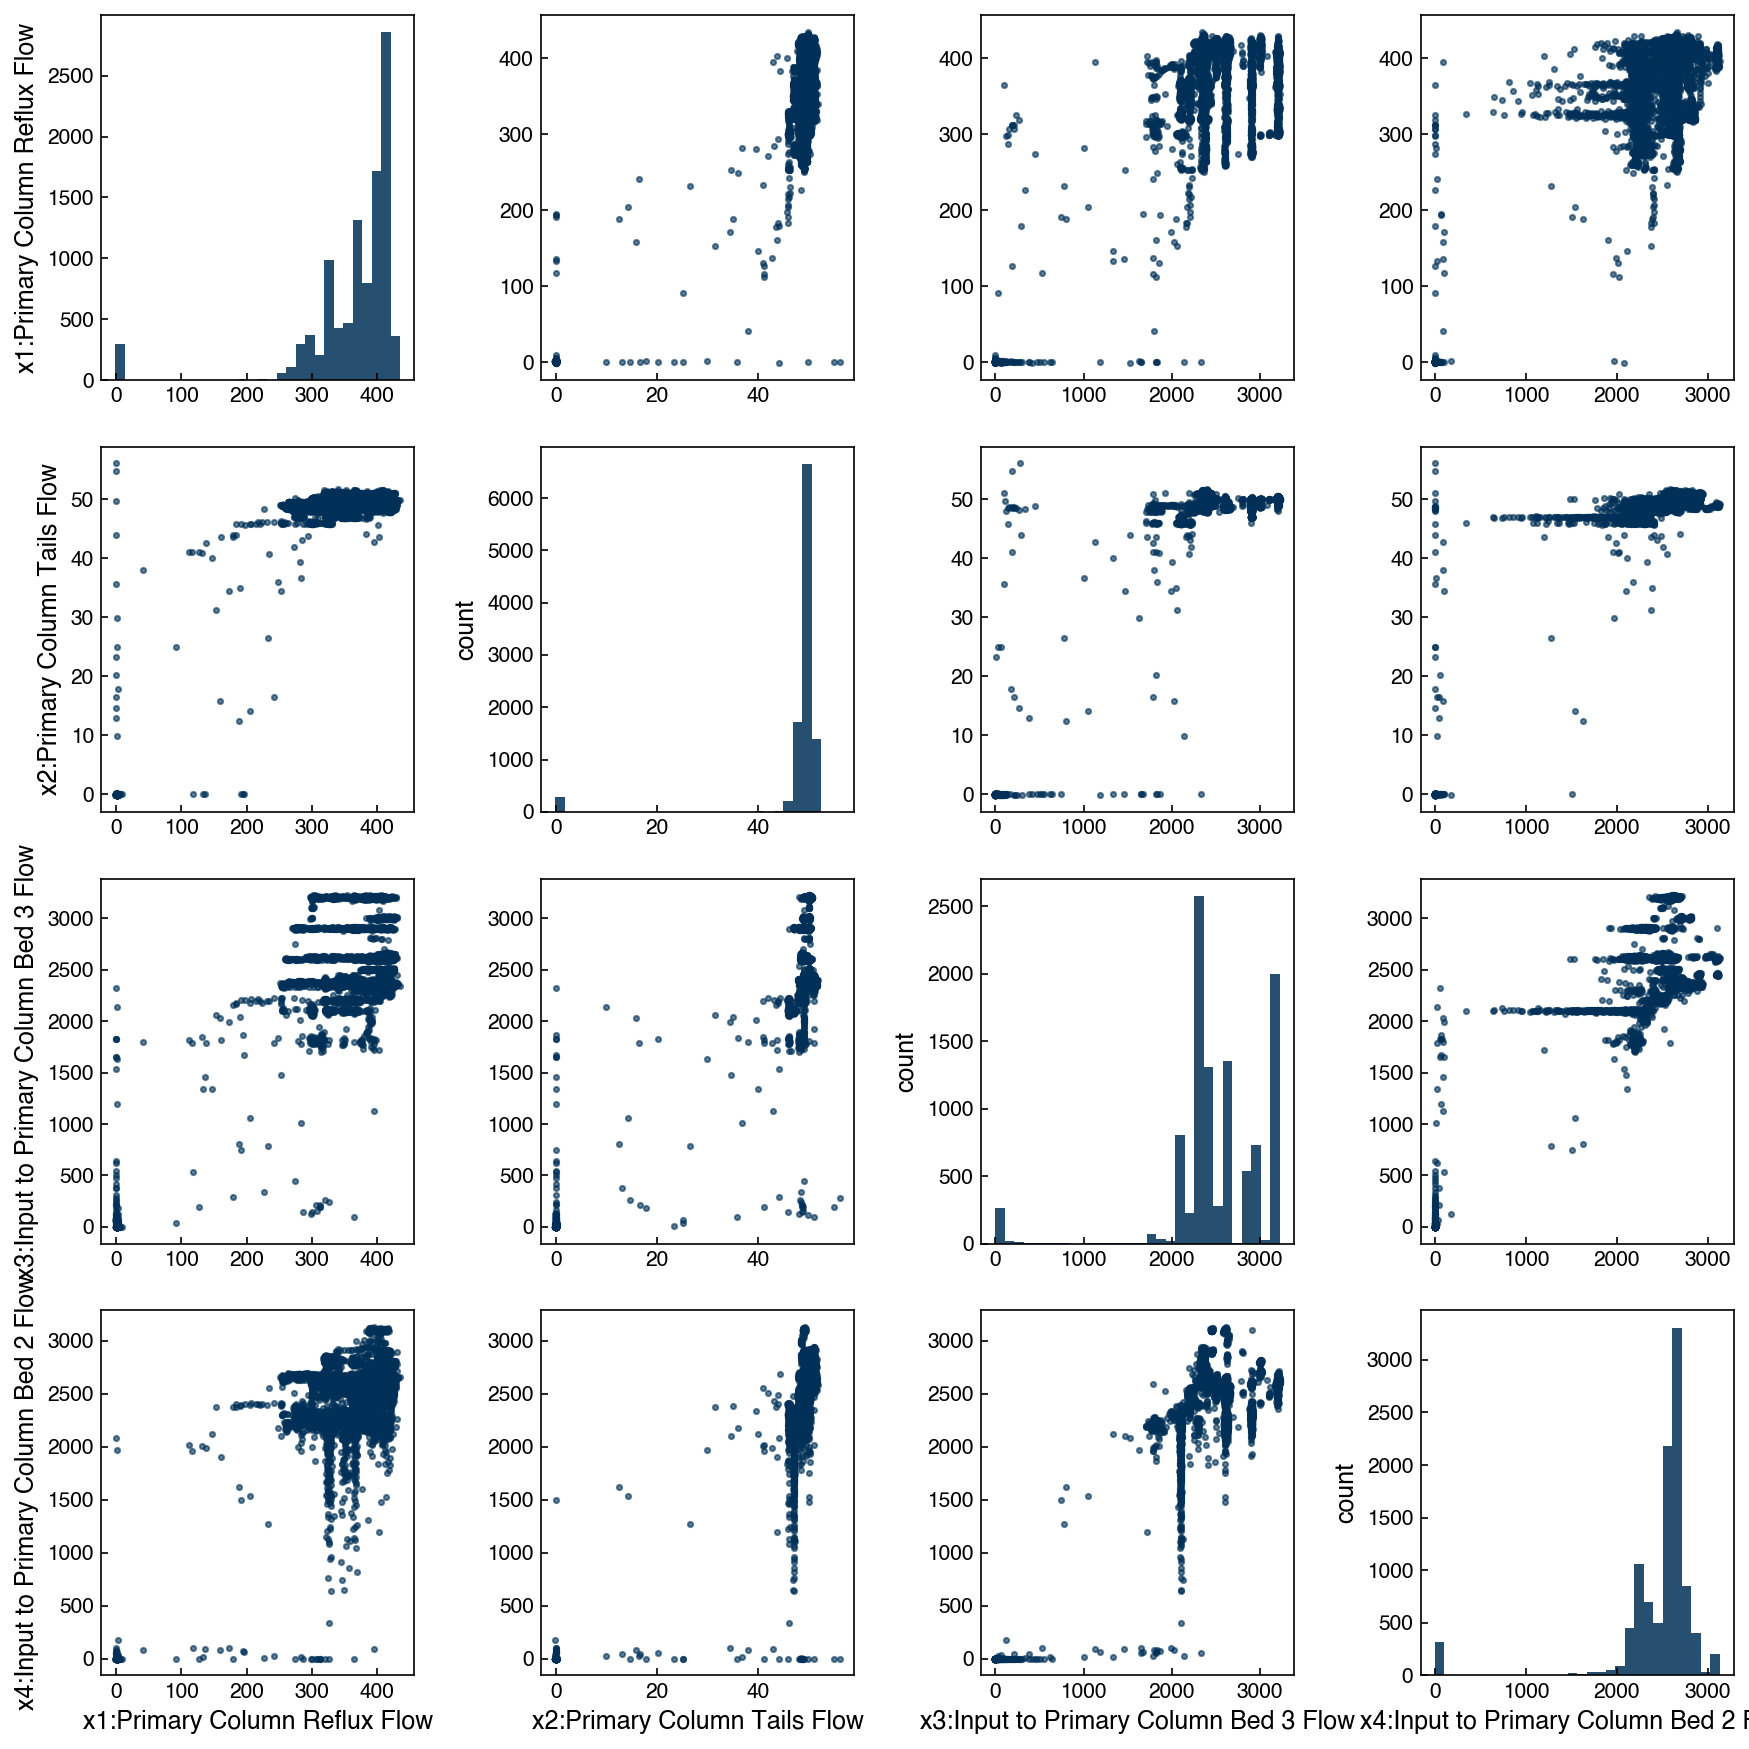

In [7]:
# Small pair grid for a handful of features
subset_idx = [0, 1, 2, 3]  # choose a small set to keep plots readable
m = len(subset_idx)
fig, axes = plt.subplots(m, m, figsize=(3*m, 3*m))

for r, ii in enumerate(subset_idx):
    for c, jj in enumerate(subset_idx):
        ax = axes[r, c]
        if r == c:
            ax.hist(X[:, ii], bins=30, alpha=0.85)
            ax.set_ylabel('count')
        else:
            ax.scatter(X[:, jj], X[:, ii], s=6, alpha=0.6)
        if r == m-1: ax.set_xlabel(x_names[jj])
        if c == 0:   ax.set_ylabel(x_names[ii])

plt.tight_layout()

At this point, nothing really jumps out in terms of correlation with the target variable, but we can still see some interesting aspects of the dataset's structure. For example, it is even more clear from this plot that some variables (e.g. `Input to Primary Column Bed`) have some discrete values, but also vary continuously in general. This is consistent with a chemical process that has several operating "set points" where it typically runs, but it is also sometimes operated at conditions outside the typical ones.
### Covariance and correlation matrices

We can also look for feature relationships through the **covariance matrix**. The covariance describes how features vary together. We will not go through the math here, but we will discuss the concepts:

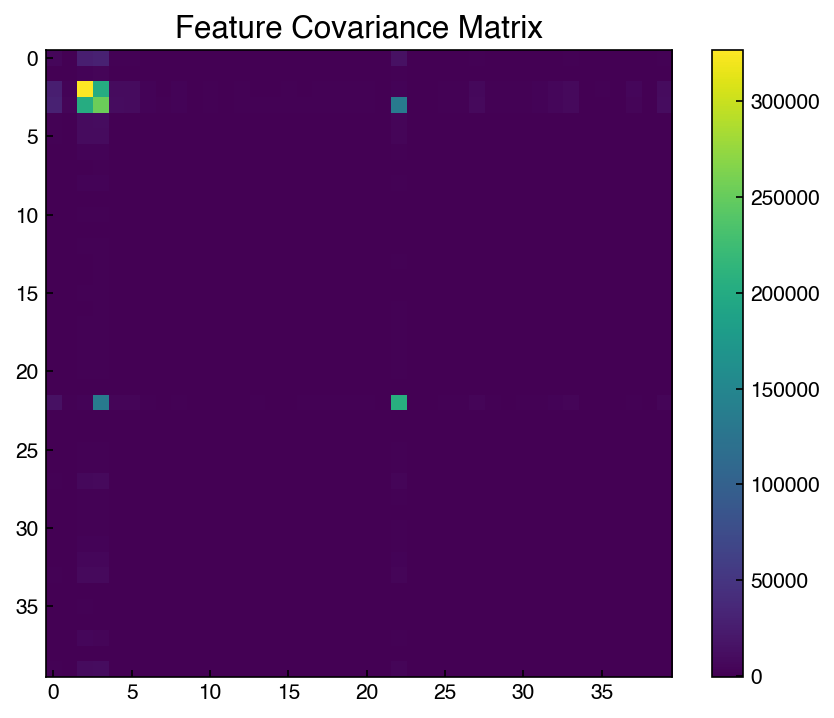

In [8]:
covar = np.cov(X.T)
fig, ax = plt.subplots(figsize=(6,5))
c = ax.imshow(covar)
ax.set_title('Feature Covariance Matrix')
fig.colorbar(c);
plt.tight_layout()

This matrix suggests that some features are highly correlated. We can inspect specific entries:

In [9]:
# Diagonal entries are variances (depend on scale); off-diagonals are covariances.
print(f'Variance of {x_names[2]}: {covar[2,2]:.3g}')
print(f'Variance of {x_names[1]}: {covar[1,1]:.3g}')
# Uncomment to inspect an off-diagonal covariance:
print(f'Covariance({x_names[2]}, {x_names[3]}): {covar[2,3]:.3g}')

Variance of x3:Input to Primary Column Bed 3 Flow: 3.26e+05
Variance of x2:Primary Column Tails Flow: 69.6
Covariance(x3:Input to Primary Column Bed 3 Flow, x4:Input to Primary Column Bed 2 Flow): 2.02e+05


These numbers are difficult to compare across features because **covariance depends on units/scale** (e.g., °C vs. bar). A scale-invariant alternative is the **correlation** matrix, which rescales by standard deviations and lies in [-1, 1]:

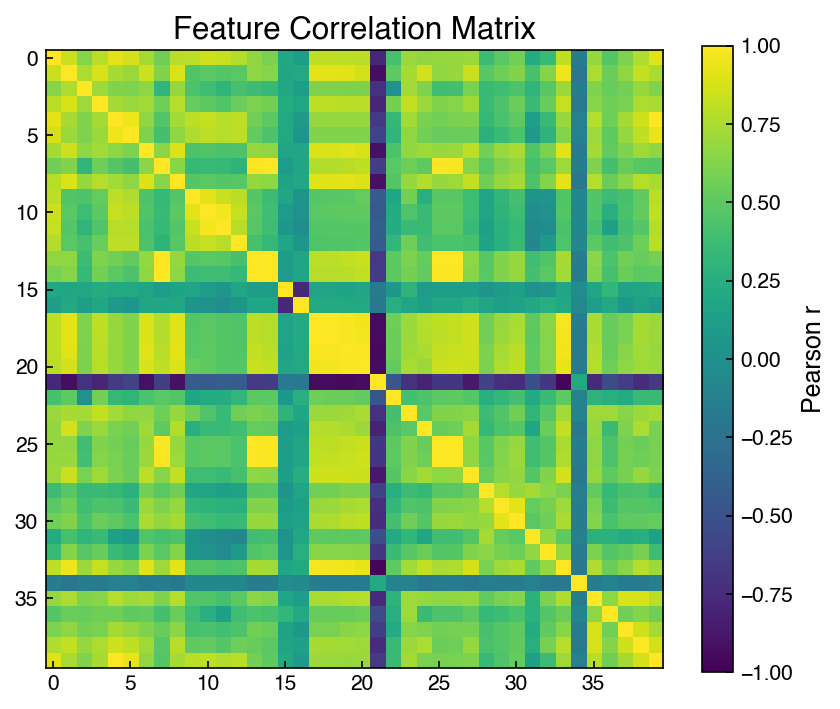

In [10]:
corr = np.corrcoef(X.T)
fig, ax = plt.subplots(figsize=(6,5))
im = ax.imshow(corr, vmin=-1, vmax=1)
ax.set_title('Feature Correlation Matrix')
fig.colorbar(im, ax=ax, label='Pearson r')
plt.tight_layout()

We will see how these two matrices are related shortly.

```{admonition} Exercise: Highly correlated bivariate scatter plots
:class: tip

1. Programmatically find the top 5 **absolute** correlations among **distinct** feature pairs (ignore the diagonal).
2. Make bivariate scatter plots for those 5 pairs (use small markers and `alpha=0.5`). Color each scatter by `y` to see whether the strongest feature–feature correlations also correspond to structure in the target.

```

## Scaling Features and Outputs

From the visualization and covariance matrix we can see that different features have very different ranges, and different units (e.g., degrees, percent, count). Scaling data is like "non-dimensionalizing" or normalizing for different units. This is often critical to ensure that certain variables are not weighted more than others.

Statistical methods do not know about physical units, so we can normalize or "scale" features to aid in comparison:

- rescaling: 0 = min, 1 = max
- mean scaling: 0 = mean, 1 = max, -1 = min
- **standard scaling: 0 = mean, 1 = standard deviation**
- unit vector: the length of each multi-dimensional vector is 1

We will typically default to **standard scaling** in this course since it has some nice properties, but you can see the [scikit-learn documentation](http://scikit-learn.org/stable/modules/preprocessing.html) for more examples and discussion.

Note that scaling is not always a good idea. Sometimes the data have units that are already consistent, or rescaling can remove important aspects of the data. Figuring out the best scaling scheme is often achieved through trial and error.

```{note}
The term "scaling" is common throughout science and engineering and has many different meanings. For example, in chemical engineering we often talk about "scaling" a process up, and in physics quantities are sometimes said to "scale" if they are proportional, leading to "scaling relationships". Even within computer science, "scaling" means different things -- the way an algorithm "scales" refers to how much time it takes as the size of the problem or the size of the computer changes. The term "feature scaling" is less ambiguous, and can also be referred to as "feature normalization".
```

It is also important to note that feature scaling is a common source of **data leakage**. Data leakage occurs when information from the testing set "leaks" into the training data, which can lead to artificially good results when the model is applied to the test set. It might seem like feature scaling is not really a "model", but in reality you are using the data to determine the parameters (mean, min, max, or standard deviation) for the scaling. It is important that you always perform any data splitting for cross validation **before** performing feature scaling, and you should only use the training data to determine the scaling parameters. When applying the feature scaling to the testing data, you will still use the parameters (e.g., mean, min, max, or standard deviation) from the training data. Think of an application scenario where you train a model to a large amount of data, but then want to apply it to a single new data point: you would not be able to calculate the mean, min, max, or standard deviation of that data point, so you would need to use the statistics of the training data instead.

In the case of the Dow chemical process data, we can look at the features and see they clearly have different units and different ranges. For example, feature 1 (Primary column tails flow) ranges from 0 to 50, and feature 2 (Input to primary column Bed 3 Flow) ranges from 0 to \~3000. While we do not necessarily know the units (since this is proprietary data), we can see that there is a difference of range. This is why the covariance matrix did not make much sense. We can rescale the data to put everything on similar scales.

First, let's do this manually:

In [11]:
X_scaled_manual = (X - X.mean(axis=0))/X.std(axis=0)
print("Minimum: {}, Maximum: {}".format(X.min(), X.max()))
print("Minimum scaled: {}, Maximum scaled: {}".format(X_scaled_manual.min(), X_scaled_manual.max()))

Minimum: -6.91425, Maximum: 5176.74
Minimum scaled: -8.12009681442378, Maximum scaled: 38.10583689480496


It is also possible to do this with `scikit-learn`:

In [12]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X) # "fit" the scaler (finds the mean and standard deviation of the data)
X_scaled = ss.transform(X) #"transform" the data by applying the standard scaler

print("Minimum scaled: {}, Maximum scaled: {}".format(X_scaled.min(), X_scaled.max()))

Minimum scaled: -8.12009681442378, Maximum scaled: 38.10583689480496


The `fit` and `transform` methods may seem unintuitive or unnecessarily complex, but this standard interface to `scikit-learn` models makes it possible to "chain" them together and use them interchangeably. We will see an example of this shortly as we create a "pipeline".

```{note}
**What could go wrong with min-max or mean scaling?**  

Min–max and mean scaling can be **highly sensitive to outliers**. A single extreme value can dominate the min/max (or mean) and compress most of the other data into a narrow interval, making patterns hard to see and potentially hurting model performance. Min-max scaling is a good option if your data are guaranteed to be within a certain range, and robust alternatives include standard scaling or scaling with quantiles or medians.
```

Now let's take a look at the covariance matrix with the rescaled data::

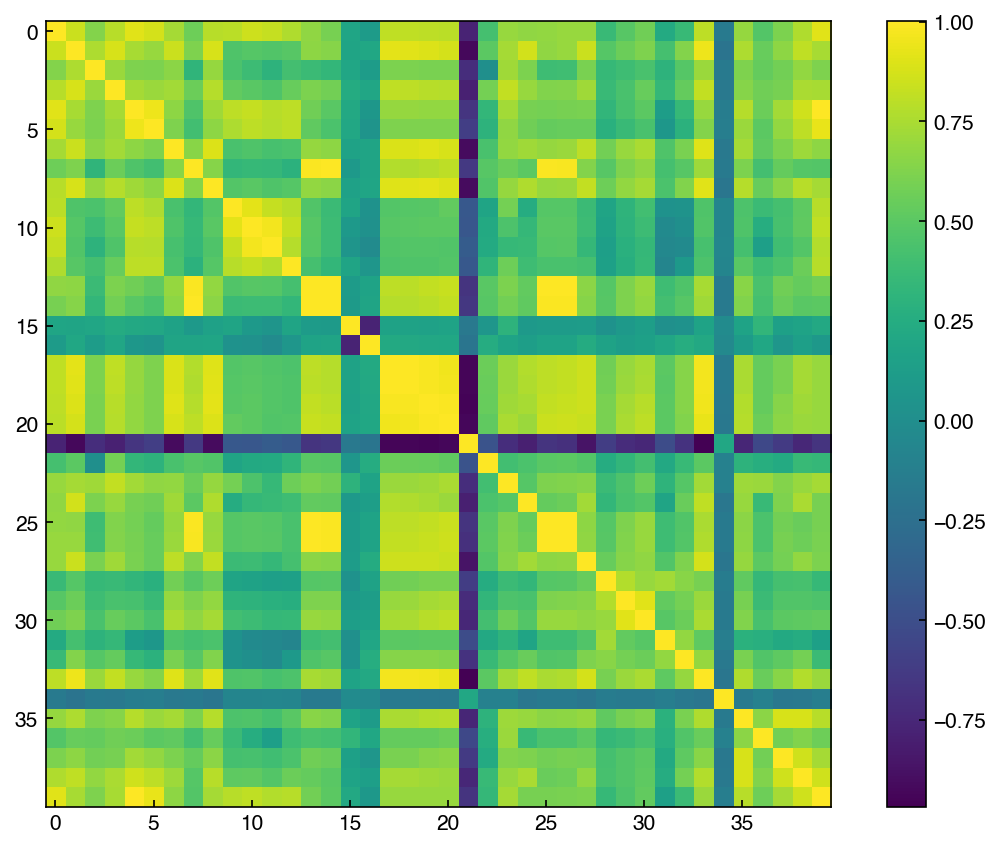

In [13]:
covar = np.cov(X_scaled.T)
fig,ax = plt.subplots()
c = ax.imshow(covar)
fig.colorbar(c);

The structure looks totally different! This is the "correlation matrix", which tells us how correlated different features are on a scale of -1 to 1. A correlation of -1 means they are perfectly anti-correlated, while 1 means they are perfectly correlated. If any features are perfectly (anti)correlated (correlation = 1 or -1) then they are linearly dependent (and won't count toward the rank).

In [14]:
# Maximum entry in convariance
print(f"max entry in covariance matrix: {np.abs(covar).max():.3f}")

max entry in covariance matrix: 1.000


We see that the maximum is 1, which suggests some features are perfectly correlated.

In [15]:
np.linalg.matrix_rank(X)

np.int64(40)

However, we see that the rank is 40, equal to the number of columns, suggesting that the data is full rank. The reason is that the diagonal entries of the standardized covariance (i.e., correlation) matrix will always be 1 since features are perfectly correlated with themselves. We see that the maximum off-diagonal is less than one (although barely), so no **different features** are perfectly correlated. This means the matrix should be full rank, and the sanity check passes.

In [16]:
# Maximum off-diagonal entry of the covariance/correlation matrix

off_diags = []
N = covar.shape[0]

max_offdiag = -1 #set to a number that must be smaller than the smallest real number
i_max = 0
j_max = 0
for i in range(N):
    for j in range(N):
        if i > j:
            entry = np.abs(covar[i,j])
            if entry > max_offdiag: #must be true on first iteration!
                max_offdiag = entry
                i_max = i
                j_max = j
            off_diags.append(np.abs(covar[i,j]))

print(f"max off-diagonal covariance: {max_offdiag:.5f} at ({x_names[i_max]}, {x_names[j_max]}) [indices: {i_max}, {j_max}]")

max off-diagonal covariance: 0.99954 at (x27: Secondary Column Base Pressure, x26: Secondary Column Head Pressure) [indices: 26, 25]


In general, if the data have been **standard scaled** (with the same ddof convention!), then the covariance matrix will range from -1 to 1 and is equivalent to a correlation matrix, which can also be computed directly from the data:

In [17]:
corr = np.corrcoef(X.T)
covar = np.cov(X_scaled.T)
np.isclose(corr, covar, atol=1e-4).all()

np.True_

We will discuss the covariance/correlation matrix much more later, but when dealing with multi-dimensional data it is always good to check.


```{admonition} Exercise: Apply and explore scaling approaches
:class: tip

1. Split `X, y` into train/test (80/20) with `random_state=0`.
2. Fit a `StandardScaler` **only on the training set**, then transform both train and test.
3. Confirm that the **training** features have mean=0 and std=1 (per feature). 
4. Check the mean and standard deviation on the **testing** features. Are they exactly equal to zero and one?
```


## Multi-Linear Regression

We can recall the general form of a linear regression model:

$$
y_i = \sum_j w_j X_{ij} + \epsilon_i
$$

Previously, we created features (columns of $X$) by transforming the original 1-dimensional input. In this case, we already have columns of $X$ provided from the data, so we can directly fit the model to the high-dimensional data matrix:

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
print(f"Train R^2: {linreg.score(X_train, y_train):.3f}")

Train R^2: 0.716


We can also scale the features before regression. In general, this can improve the accuracy or numerical stability of the model, or occasionally decrease the accuracy. As noted previously, one common pitfall in feature scaling is "data leakage", where data from the test/validation set is used to scale the data. Sometimes, this has little effect, but in other cases it can have very significant effects. It is possible to use the `scikit-learn` "pipeline" functionality to create a leakage-safe model that can easily be combined with hyperparameter optimization and other `scikit-learn` workflows:

In [19]:
#leakage-safe scaling with scikit-learn
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
pipe = make_pipeline(StandardScaler(), LinearRegression())
pipe.fit(X_train, y_train)
r2_train = pipe.score(X_train, y_train)
print(f"Train R^2 (pipeline with scaling): {r2_train:.3f}")

Train R^2 (pipeline with scaling): 0.716


The `make_pipeline` function chains preprocessing and modeling steps into a single estimator that fits and predicts in the correct order. For example,
`pipe = make_pipeline(StandardScaler(), LinearRegression())`
creates a workflow that:

- **Fits scaling only on training data** when you call `pipe.fit(X_train, y_train)`, preventing leakage.
- **Applies the same scaling to new/test data** automatically inside `pipe.predict(X_test)`.
- **Plays nicely with cross-validation** (`cross_val_score`, `GridSearchCV`): the scaler is refit **inside each fold**. When tuning hyperparameters of a downstream model, use the step name with a double underscore, e.g. `{'ridge__alpha': [0.1, 1, 10]}` for `make_pipeline(StandardScaler(), Ridge())`.
- Lets you **access the final model** with `pipe[-1]` or `pipe.named_steps['linearregression']` to inspect coefficients, etc.

This pattern is the standard way to keep preprocessing and modeling coupled, avoid data leakage, and ensure reproducible evaluation. You can also use the approach to chain together different types of models or functions to create complex pipelines that act as a single estimator. 

We see that the $r^2$ score is 0.71, which is not terrible, but not great either. We also see that it is identical to the un-scaled model. This is because, for linear models, any linear scaling approach will just change the magnitude of the coefficients. It can improve numerical stability, especially if some features have very different magnitudes, but in general it should not affect the results. However, for non-linear models (e.g. KRR, neural networks) scaling can have a much more significant impact.

We cannot really visualize the model like we did for the 1-dimensional case, since we have 40-dimensional inputs. However, we can make a **parity plot** to visualize the performance:

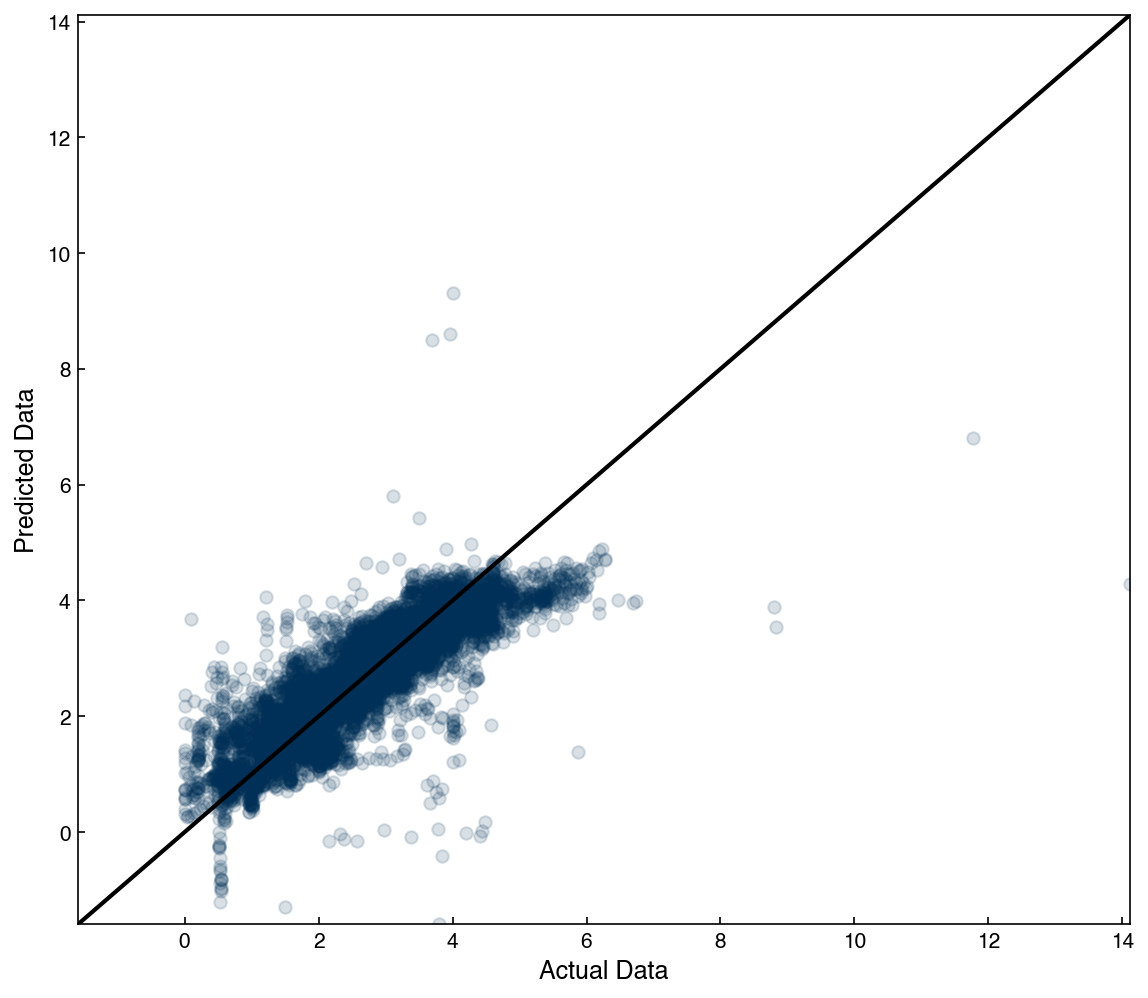

In [20]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 7))

yhat = pipe.predict(X)
y_true = y.ravel()
y_pred = yhat.ravel()
ax.scatter(y_true, y_pred, alpha=0.15)

# 45-degree reference line
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
ax.plot(lims, lims, '-k')
ax.set_xlim(lims); ax.set_ylim(lims)

ax.set_xlabel('Actual Data')
ax.set_ylabel('Predicted Data');

This looks reasonable, although there are quite a few outliers. We should also remember that we used hold-out here, so we can check the $r^2^ on the testing set to ensure there was no overfitting:

In [21]:
r2_test = pipe.score(X_test, y_test)

print(f"r^2 train = {r2_train:.3f}")
print(f"r^2 test  = {r2_test:.3f}")

r^2 train = 0.716
r^2 test  = 0.711


We see that they are comparable, which indicates that we have not over-fit. We can also visualize both training and testing errors with a parity plot:

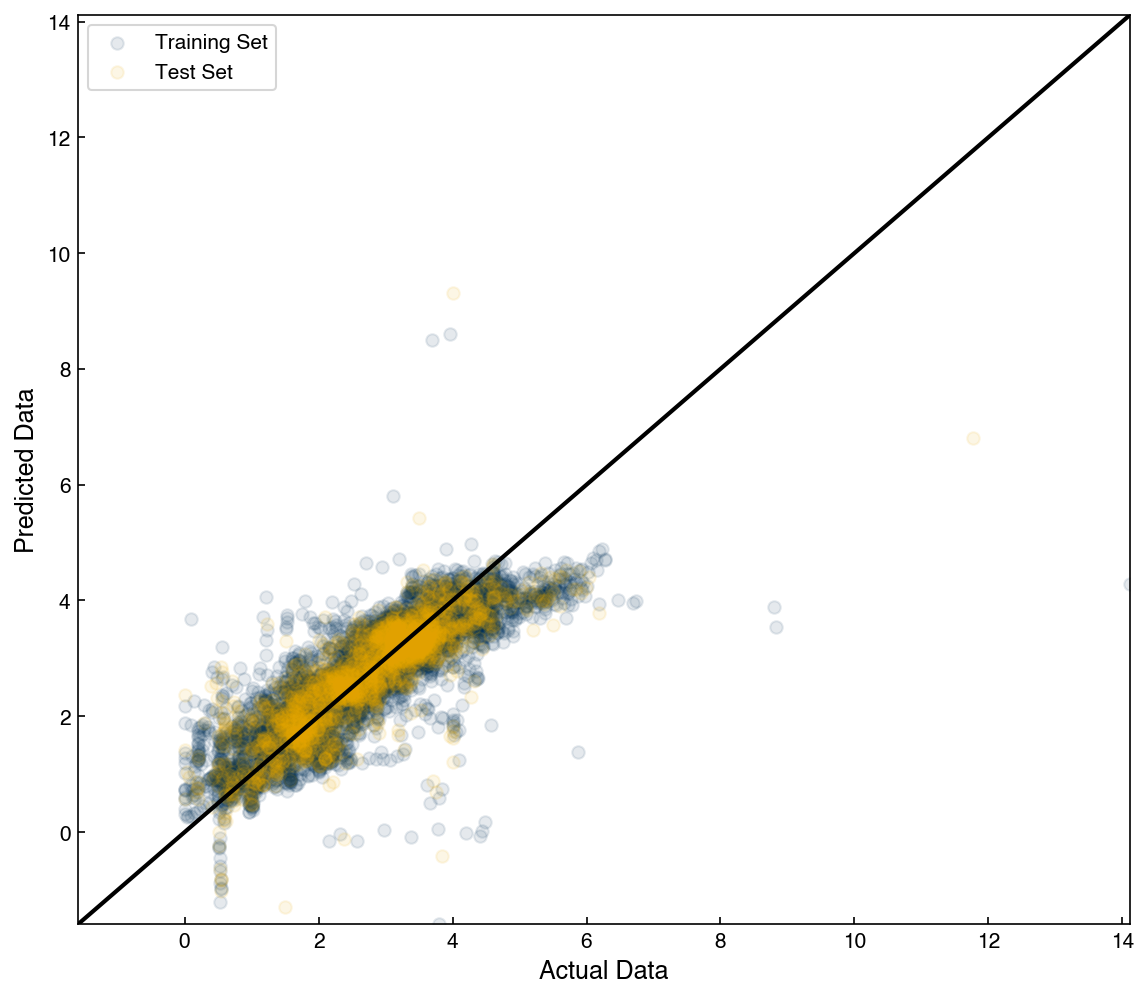

In [22]:
fig, ax = plt.subplots(figsize=(8, 7))

yhat_train = pipe.predict(X_train).ravel()
yhat_test = pipe.predict(X_test).ravel()
ax.scatter(y_train.ravel(), yhat_train, alpha=0.10, label='Training Set')
ax.scatter(y_test.ravel(),  yhat_test,  alpha=0.10, label='Test Set')

# 45-degree reference line common to both
all_true = np.concatenate([y_train.ravel(), y_test.ravel()])
all_pred = np.concatenate([yhat_train, yhat_test])
lims = [min(all_true.min(), all_pred.min()), max(all_true.max(), all_pred.max())]
ax.plot(lims, lims, '-k')
ax.set_xlim(lims); ax.set_ylim(lims)

ax.set_xlabel('Actual Data')
ax.set_ylabel('Predicted Data')
ax.legend();

We can see that these look comparable, which confirms that we have not over-fit the model. It is always a good idea to check the parity plot to see if any patterns stand out!

This basic linear regression model is simple, but by testing it we now have a **baseline model**. This tells us that if we have any results worse than this we have a really bad model!

```{note}
**What is a “baseline model,” and why use one?**  
A baseline is the **simplest reasonable model** you can implement quickly and evaluate fairly. It establishes a **reference performance** so you can tell whether more complex methods add real value. A good baseline is:

- **Simple/fast** and easy to explain (e.g., `make_pipeline(StandardScaler(), LinearRegression())`).
- **Evaluated fairly** with proper splitting/CV, the same metrics, and fixed randomness.
- **Reproducible** with recorded settings and code.

If a new approach cannot **beat the baseline on held‑out data**, revisit your data, features, or evaluation before adding complexity.
```

We see that the performance of the model is not great, and to improve things we will need to add some non-linearity. In 1-dimensional space we achieved this by adding transforms of the features as new features. However, this is more challenging in a high-dimensional space since the number of features will scale with the number of dimensions.

```{note}
**How many features would result if third-order interactions were considered?**  

A simple estimate can be obtained by taking the cube of the number of features, which would be $40^3 = 64,000$, but this is a significant over-estimate since there will be redundant combinations. A more accurate estimate requires some combinatorics: If you include **all degree-3 polynomial terms with replacement** (e.g., $x_i^3,\; x_i^2 x_j,\; x_i x_j x_k$), the count is $\binom{40 + 3 - 1}{3} = \binom{42}{3} = 11,480$, which is still larger than the number of data points we have.

This shows that the number of features grow **combinatorially** as the number of dimensions increases, and illustrates why naive feature expansion becomes impractical in high dimensions.
```

Kernel-based methods are very commonly used for high-dimensional spaces because they account for non-linear interactions, but the number of features does not exceed the number of data points. In your homework you will explore the application of KRR to this dataset.


```{admonition}
:class: tip

Compare linear regression on the **original** features and on **rescaled** features.

1. Split the raw data with `train_test_split(X, y, test_size=0.3, random_state=0)`.
2. Fit `LinearRegression()` on the **raw** training features; record train/test $r^2$.
3. Fit a pipeline `make_pipeline(StandardScaler(), LinearRegression())` on the **same** split; record train/test $r^2$.
4. Show that the **predictions are (nearly) identical** on the test set by printing the max absolute difference between the two prediction vectors and the absolute difference in test $r^2$.
5. Compare the **coefficients**: print the top-10 by absolute value for (a) the raw model and (b) the scaled model. *(Optional)* Recover coefficients on the **raw scale** from the pipeline (using the scaler’s `mean_` and `scale_`) and verify they match the raw model’s coefficients.

```

## Dimensionality Reduction

An alternative approach to creating high-dimensional models is to reduce the dimensionality. We will briefly look at some techniques here, and revisit this idea later in the course.

### Forward Selection

A very intuitive way to reduce dimensions is to just select a subset of the original features. The simplest strategy to select or rank features is to try them one-by-one, and keep the best feature at each iteration:

In [23]:
import numpy as np
from sklearn.linear_model import LinearRegression

N_features = 40
X_subset = X_scaled.copy()
x_names_subset = np.array(x_names, dtype=object).copy()
new_X = []
new_X_names = []

while len(new_X) < N_features and X_subset.shape[1] > 0:
    r2_list = []
    for j in range(X_subset.shape[1]):
        model = LinearRegression()  # create a linear regression model instance
        xj = X_subset[:, j].reshape(-1, 1)
        model.fit(xj, y)            # fit the model
        r2 = model.score(xj, y)     # r^2 for this single feature
        r2_list.append((r2, j))
    # select highest r^2 value
    r2_list.sort(key=lambda t: t[0])
    r2_max, j_max = r2_list[-1]
    new_X.append(X_subset[:, j_max].copy())
    new_X_names.append(x_names_subset[j_max])
    # remove selected feature from the pool
    x_names_subset = np.delete(x_names_subset, j_max)
    X_subset = np.delete(X_subset, j_max, axis=1)

print('The {} most linearly correlated features are:'.format(len(new_X)))
print(new_X_names)

new_X = np.array(new_X).T  # shape: (n_samples, k)

The 40 most linearly correlated features are:
['x10:Primary Column Bed1 DP', 'x5:Primary Column Feed Flow from Feed Column', 'x11:Primary Column Bed2 DP', 'x6:Primary Column Make Flow', 'x13:Primary Column Bed4 DP', 'x40: Feed Column Tails Flow', 'x24: Secondary Column Tails Flow', 'x1:Primary Column Reflux Flow', 'x12:Primary Column Bed3 DP', 'x4:Input to Primary Column Bed 2 Flow', 'x37: Feed Column Tails Flow to Primary Column', 'x21:Primary Column Bed 1 Temperature', 'x3:Input to Primary Column Bed 3 Flow', 'x26: Secondary Column Head Pressure', 'x20:Primary Column Bed 2 Temperature', 'x31: Secondary Column Bed 2 Temperature', 'x27: Secondary Column Base Pressure', 'x14:Primary Column Base Pressure', 'x7:Primary Column Base Level', 'x19:Primary Column Bed 3 Temperature', 'x9:Primary Column Condenser Reflux Drum Level', 'x39: Feed Column Steam Flow', 'x18:Primary Column Bed 4 Temperature', 'x36: Feed Column Recycle Flow', 'x2:Primary Column Tails Flow', 'x34: Secondary Column Tails 

```{note}
**About this "forward selection" loop**  
This implementation performs **univariate ranking** (pick best single feature, then the next best single feature, etc.). A full **forward stepwise** method would re-fit a multi-feature model at each step using the features already chosen **plus** each candidate feature, selecting the one that improves the model the most. We use the simpler ranking here for speed and clarity.
```

We can see how the $r^2$ score changes with the reduced features:

In [24]:
model = LinearRegression()  # create a linear regression model instance
model.fit(new_X, y)         # fit the model on the selected features
r2 = model.score(new_X, y)  # r^2 on the same data
print("r^2 = {}".format(r2))

r^2 = 0.7168241690081087


We see that with just 4 features the model performance is substantially reduced. We can keep increasing the number until it is comparable to the full model.

```{admonition}
:class: tip

Below we compute $r^2$ as we include more ranked features and identify the **minimum** number of features needed to reach $r^2\ge 0.60$.
```

Minimum k achieving r^2 ≥ 0.6: 17 (r^2 = 0.622)


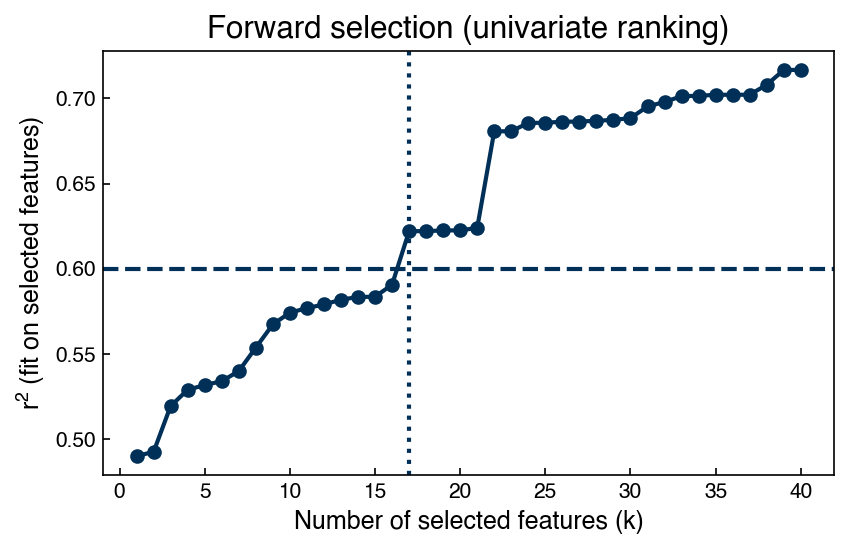

In [25]:
k_max = new_X.shape[1]
r2_path = []
ks = np.arange(1, k_max + 1)

for k in ks:
    Xk = new_X[:, :k]
    model = LinearRegression().fit(Xk, y)
    r2_path.append(model.score(Xk, y))

r2_path = np.array(r2_path)
# first k reaching target (if any)
target = 0.60
hit = np.argmax(r2_path >= target) if np.any(r2_path >= target) else None

plt.figure(figsize=(6,4))
plt.plot(ks, r2_path, 'o-')
plt.axhline(target, linestyle='--')
if hit is not None and r2_path[hit] >= target:
    plt.axvline(ks[hit], linestyle=':')
plt.xlabel('Number of selected features (k)')
plt.ylabel('$r^2$ (fit on selected features)')
plt.title('Forward selection (univariate ranking)')
plt.tight_layout()

if hit is not None and r2_path[hit] >= target:
    print(f"Minimum k achieving r^2 ≥ {target}: {ks[hit]} (r^2 = {r2_path[hit]:.3f})")
else:
    print(f"Target r^2 ≥ {target} not reached with up to {k_max} features.")

Be careful, since just because features are not *linearly* correlated does not mean that they are not *non-linearly* correlated (in other words, we might reject a feature that is actually very descriptive, if that description is highly non-linear) . There is also no guarantee that we are not finding correlated features, since if one feature has a high correlation with the output, and is also correlated with another feature, then that feature will also be correlated with the output. More advanced forward selection strategies can be used to reduce this, as shown with a standard implementation below:

**Standard scikit-learn (full forward stepwise) feature selection**

In [26]:
# Full forward stepwise selection using scikit-learn's SequentialFeatureSelector (SFS)
from sklearn.feature_selection import SequentialFeatureSelector

est = make_pipeline(StandardScaler(), LinearRegression())

# Choose how many features to keep (example: 10) and use forward stepwise with cross-validation
sfs = SequentialFeatureSelector(
    est, n_features_to_select=10, direction="forward",
    scoring="r2", cv=5, n_jobs=-1
).fit(X, y.ravel())

selected_idx = sfs.get_support(indices=True)
selected_names = [x_names[i] for i in selected_idx]

print("Selected feature indices:", selected_idx)
print("Selected feature names:", selected_names)

# Transform X to the selected subset and fit a final model on the whole dataset
X_fs = sfs.transform(X)
final_model = LinearRegression().fit(X_fs, y)
print("r^2 on full data using selected subset:", final_model.score(X_fs, y))

Selected feature indices: [ 8  9 15 16 23 24 28 32 34 36]
Selected feature names: ['x9:Primary Column Condenser Reflux Drum Level', 'x10:Primary Column Bed1 DP', 'x16:Primary Column Tails Temperature', 'x17:Primary Column Tails Temperature 1', 'x24: Secondary Column Tails Flow', 'x25: Secondary Column Tray DP', 'x29: Secondary Column Tray 3 Temperature', 'x33: Secondary Column Tray 1 Temperature', 'x35: Secondary Column Tails Concentration', 'x37: Feed Column Tails Flow to Primary Column']
r^2 on full data using selected subset: 0.6055868410819696


Note that the features selected with this more sophisticated approach differ from the naive approach, and that we are able to reach $r^2 > 0.6$ with just 10 features, instead of the 17 required above. This is because many of the features are highly correlated (as we already saw with the correlation matrix above), so some of the features selected in the naive univariate ranking were partially redundant. The `SequentialFeatureSelector` approach above is much less tranparent, and uses some more advanced `scikit-learn` features, but it also yields good results with relatively little code. Don't worry if you don't understand all the details: the main point is that there are different ways to do feature selection, and each strategy can yield different results.

```{note}
**Choosing `n_features_to_select`**  
`SequentialFeatureSelector` requires you to specify how many features to keep. In practice you can sweep over `k` (e.g., 1–20) and pick the smallest `k` that reaches a target cross-validated score, or use a validation curve to balance performance and parsimony.
```

### Principal component analysis

An alternative strategy to avoid having correlated features is to ensure that features are orthogonal using the eigenvectors of the covariance matrix. The code below finds the eigenvectors of the covariance matrix, which we know will be orthogonal (from the "linear algebra" module).

In [27]:
import numpy as np

# Use the (standardized) covariance matrix for PCA
cov = np.cov(X_scaled.T)

# For symmetric matrices (covariance), use eigh (guaranteed real eigenvalues)
vals, vecs = np.linalg.eigh(cov)  # vals ascending
# sort descending by variance explained
idx = np.argsort(vals)[::-1]
PCvals = vals[idx]
PCvecs = vecs[:, idx]

# sanity checks: orthonormal eigenvectors
print('dot(PC1, PC1) =', float(np.dot(PCvecs[:, 0], PCvecs[:, 0])))
print('dot(PC1, PC2) =', float(np.dot(PCvecs[:, 0], PCvecs[:, 1])))

dot(PC1, PC1) = 1.0000000000000004
dot(PC1, PC2) = 4.163336342344337e-17


These eigenvectors are orthogonal, and represent a linear transformation of the original features into an orthogonal space, which removes feature correlation. It turns out that by taking the eigenvalues of the covariance matrix you are actually doing something called **principal mponent analysis**, which is a classic dimensionality reduction technique. The eigenvectors of the covariance matrix identify the "natural" coordinate system of the data. We can visualize this with some toy data in two dimensions (note that the script to generate this file is available in "settings"):

```{figure} images/pca_illustration.png
:width: 800px
:align: center

Toy data in original 2-dimensional coordinates (left) and in rotated "principal component vector" coordinates (right).
```

```{note}
**PCA coordinates vs. Cartesian coordinates**  
Think of the usual x–y axes as a fixed Cartesian frame. PCA rotates this frame to a new set of perpendicular axes (the principal components) that align with the directions of greatest variance in the data—similar to choosing an origin and x- and y-axis when solving an engineering problem. The new axes are orthonormal (like the unit vectors i, j, k), and projecting data onto them is just taking dot products with these unit vectors. In this rotated frame, covariances vanish (the off‑diagonals go to ~0), so variability is concentrated along a few axes, making analysis and modeling simpler, but the underlying data is not really changed.
```

The eigenvalues provide the variance in each direction, and we can use this to determine how much variance each principal component contributes:

Total variance (trace of covariance): 40.00388500388503
First 5 explained variance ratios: [0.5851 0.1046 0.0583 0.0441 0.0341]
Components needed for ≥90% variance: 8


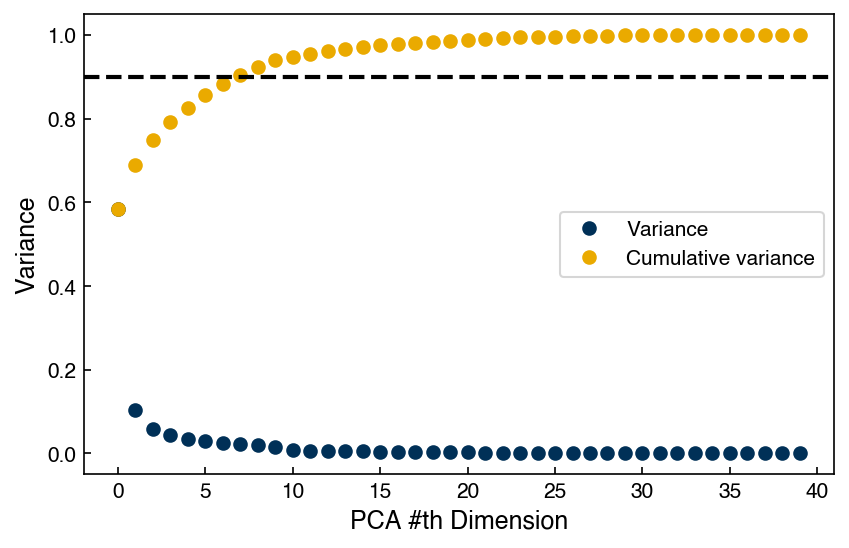

In [28]:
import numpy as np
import matplotlib.pyplot as plt

total_variance = np.sum(PCvals)
explained_variance = PCvals / total_variance  # already sorted desc

print('Total variance (trace of covariance):', float(total_variance))
print('First 5 explained variance ratios:', np.round(explained_variance[:5], 4))

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(explained_variance, 'o', label='Variance')
ax.plot(np.cumsum(explained_variance), 'o', label='Cumulative variance')
ax.axhline(0.9, linestyle='--', color='k')
ax.set_xlabel('PCA #th Dimension')
ax.set_ylabel('Variance')
ax.legend(loc='best');

# Report how many components capture 90% variance
k90 = np.searchsorted(np.cumsum(explained_variance), 0.9) + 1
print(f"Components needed for ≥90% variance: {k90}")

We can use this to say how many principal components are needed to capture a specified fraction of the variance (e.g., 90%).

Finally, we can "project" the data onto the principal components. This is equivalent to re-defining the axes of the data. If we take the covariance of this rotated data, we will see that all of the features are now uncorrelated:

Projection shape: (10297, 40)


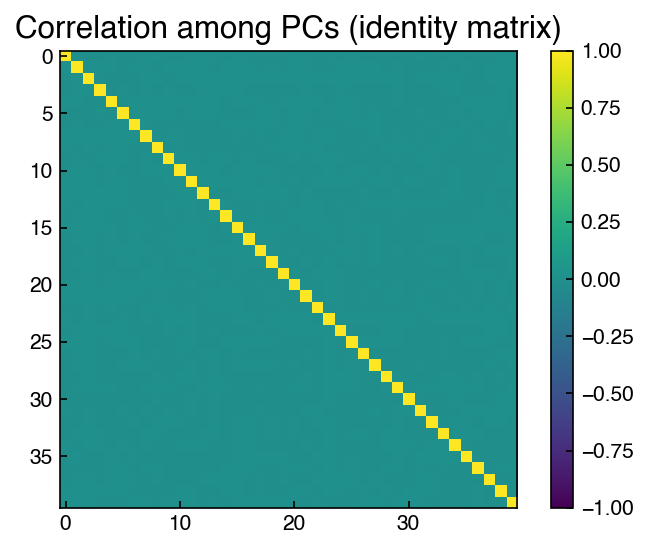

In [29]:
PC_projection = np.dot(X_scaled, PCvecs)
print('Projection shape:', PC_projection.shape)

corr_PCs = np.corrcoef(PC_projection.T)
fig, ax = plt.subplots(figsize=(5,4))
c = ax.imshow(corr_PCs, vmin=-1, vmax=1)
fig.colorbar(c);
ax.set_title('Correlation among PCs (identity matrix)');

After projection, we still have 40 features but they are now orthogonal - there is no covariance! This means that each one contains unique information.


We will talk a lot more about PCA throughout the course, but for now you should know:

- Principal component vectors are obtained from the eigenvectors of the covariance matrix
- Principal components are orthogonal
- Principal components explain the variance in multi-dimensional data
- Data can be projected onto principal components


```{admonition}
:class: tip

Using `sklearn.decomposition.PCA`, verify that scikit-learn's results match the manual PCA above.

1. Fit `PCA()` on `X_scaled`. Inspect the key attributes: `n_components_`, `components_` (principal axes), `explained_variance_`, `explained_variance_ratio_`, `singular_values_`, and `mean_`.
2. Compare `explained_variance_` with the eigenvalues you computed above (`PCvals`). They should match (within numerical tolerance).
3. Compare principal axes: `components_.T` should equal `PCvecs` **up to sign**. (Hint: compute `R = PCvecs.T @ components_.T` and use `np.sign(np.diag(R))` to align signs.)
4. Compare scores/projections: `pca.transform(X_scaled)` should match your `PC_projection` **up to the same signs**.
5. Plot the explained variance ratio and its cumulative sum; confirm it matches the manual curves.

```


## Principal Component Regression

We can also use the projected data as inputs to a regression model. This is called **principal component regression** (PCR):

In [30]:
from sklearn.linear_model import LinearRegression

# Use the PCA projection computed earlier in this topic (PC_projection)
model = LinearRegression()  # create a linear regression model instance
model.fit(PC_projection, y)  # fit the model
r2 = model.score(PC_projection, y)  # r^2 on the same data
print(f"r^2 = {r2:.3f}")

r^2 = 0.717


Let's compare this to the original data:

In [31]:
model = LinearRegression()  # create a linear regression model instance
model.fit(X_scaled, y)      # fit the model on scaled original features
r2 = model.score(X_scaled, y)
print(f"r^2 = {r2:.3f}")

r^2 = 0.717


We see that the answer is the same. This is because we are still ultimately including all the same information. However, if we want to reduce the number of features we will see a difference:

In [32]:
N = 8

model_PC = LinearRegression()
model_PC.fit(PC_projection[:, :N], y)
r2 = model_PC.score(PC_projection[:, :N], y)
print(f"r^2 PCA = {r2:.3f}")

model = LinearRegression()
model.fit(X_scaled[:, :N], y)
r2 = model.score(X_scaled[:, :N], y)
print(f"r^2 regular = {r2:.3f}")

r^2 PCA = 0.581
r^2 regular = 0.476


```{note}
**Why is a PCR model not always better than direct linear regression?**  
PCA orders directions by **variance in X**, not by how well they **predict y**. A high‑variance component can be weakly related (or unrelated) to the target, while a lower‑variance component might carry most of the predictive signal. PCR is unsupervised in its dimensionality reduction; it ignores `y` when choosing components.
```

The PCA projection collects as much information as possible in each feature and orders components by variance. We can also check them one‑by‑one to see how they correlate:

In [33]:
score_list = []
for j in range(PC_projection.shape[1]):
    model = LinearRegression()
    xj = PC_projection[:, j].reshape(-1, 1)
    model.fit(xj, y)
    r2 = model.score(xj, y)
    score_list.append((r2, j))

score_list.sort(reverse=True)
for r2j, j in score_list:
    print(f"PC{j:02d} : r^2 = {r2j:.3f}")

PC01 : r^2 = 0.207
PC00 : r^2 = 0.174
PC06 : r^2 = 0.061
PC07 : r^2 = 0.060
PC04 : r^2 = 0.044
PC25 : r^2 = 0.017
PC08 : r^2 = 0.016
PC05 : r^2 = 0.014
PC02 : r^2 = 0.013
PC16 : r^2 = 0.013
PC33 : r^2 = 0.012
PC18 : r^2 = 0.009
PC09 : r^2 = 0.009
PC15 : r^2 = 0.008
PC03 : r^2 = 0.007
PC21 : r^2 = 0.007
PC31 : r^2 = 0.006
PC22 : r^2 = 0.005
PC14 : r^2 = 0.004
PC11 : r^2 = 0.003
PC39 : r^2 = 0.003
PC38 : r^2 = 0.003
PC10 : r^2 = 0.002
PC27 : r^2 = 0.002
PC32 : r^2 = 0.002
PC13 : r^2 = 0.002
PC37 : r^2 = 0.002
PC20 : r^2 = 0.002
PC28 : r^2 = 0.001
PC12 : r^2 = 0.001
PC36 : r^2 = 0.001
PC34 : r^2 = 0.001
PC24 : r^2 = 0.001
PC26 : r^2 = 0.001
PC17 : r^2 = 0.000
PC35 : r^2 = 0.000
PC30 : r^2 = 0.000
PC19 : r^2 = 0.000
PC29 : r^2 = 0.000
PC23 : r^2 = 0.000


We see that the second principal component is actually the best, the first is the second best, and the seventh is third best. This is because the principal components only use variance of the inputs, which may or may not correlate to the outputs.&#x20;

It is common to use PCA or other dimensionality reduction techniques prior to regression when working with high-dimensional data. It is often possible to construct models that have better performance with fewer input dimensions, especially when working with non-linear models. However, it is important to note that **each principal component feature is a linear combination of _all_ input features.** In other words, you still need to use all of the features to construct a PCR model. If you are trying to reduce the information that goes into the model (instead of just the dimensionality of the model), then it is necessary to use feature selection techniques instead of or in addition to principal component analysis.

### Partial Least Squares (PLS)

Unlike PCA—which is **unsupervised** and finds directions of maximum variance in **X**—Partial Least Squares is **supervised**: it finds latent components that maximize the **covariance between X and y**. As a result, PLS components are chosen to be predictive of the target. PLS is especially helpful when there are many collinear features and relatively few samples. We will return to PLS and supervised dimensionality reduction later in the course, but it is useful to contrast it with principal component regression.

In [34]:
# PLS via scikit-learn (with scaling and a held-out test split)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Choose number of latent components (tune this via CV in practice)
pls_k = 8
pipe_pls = make_pipeline(StandardScaler(), PLSRegression(n_components=pls_k))
pipe_pls.fit(X_train, y_train.ravel())
print(f"PLS (k={pls_k}) train r^2: {pipe_pls.score(X_train, y_train):.3f}")
print(f"PLS (k={pls_k})  test r^2: {pipe_pls.score(X_test,  y_test):.3f}")

PLS (k=8) train r^2: 0.672
PLS (k=8)  test r^2: 0.701


```{note}
**Tuning PLS components**  
It is possible to use cross-validation to select `n_components`. With a pipeline, you can use `GridSearchCV` and the step name `plsregression__n_components`, e.g. `{'plsregression__n_components': range(1, min(20, X.shape[1]) + 1)}`. 
```

### A note on neural networks
Neural networks (including “deep learning”) are among the best-known examples of *high-dimensional regression* models. We do not cover them here because they introduce additional concepts (e.g., network architectures, activation functions, backpropagation/optimizers, and regularization) and are challenging to use well in practice due to many hyperparameters and training options. Entire courses are dedicated to neural networks. If this topic interests you, consider exploring a dedicated deep-learning resource (e.g. the textbook *Deep Learning* by Goodfellow, Bengio, and Courville) after you are comfortable with the basic concepts and ideas developed in this course.


```{admonition} Exercise: Making a PCA pipeline
:class: tip

1. Split the data with `train_test_split(X, y, test_size=0.3, random_state=0)`.
2. Build two pipelines:
   - `pipe_lr = make_pipeline(StandardScaler(), LinearRegression())`
   - `pipe_pcr_k = make_pipeline(StandardScaler(), PCA(n_components=k), LinearRegression())`
solute difference in $r^2$).
3. Show that when `k` is equal to the total number of features, the results are the same. 
```


(sec:2.4-additional-reading)=
## Additional reading

- (hastie-esl-ch3)= Hastie, Tibshirani, & Friedman (2009). *The Elements of Statistical Learning*, 2nd ed., Ch. 3–4 (Linear Methods; Basis Expansions).
- (islr-ch6-7)= James, Witten, Hastie, & Tibshirani (2013). *An Introduction to Statistical Learning*, Ch. 6–7 (Linear Model Selection; Moving Beyond Linearity).
- (bishop-pca)= Bishop, C. M. (2006). *Pattern Recognition and Machine Learning*, Ch. 12 (Dimensionality Reduction).
- (wold-pls)= Wold, S., Sjöström, M., & Eriksson, L. (2001). “PLS-regression: a basic tool of chemometrics.” *Chemometrics and Intelligent Laboratory Systems*, **58**(2), 109–130.
- (sklearn-pca)= Scikit-learn User Guide: Decomposition — Principal Component Analysis.
- (sklearn-pls)= Scikit-learn User Guide: Partial Least Squares Regression.